# Introducción al Aprendizaje Automático: Taller 2



## Predicción de Riesgo Crediticio

El objetivo de este taller es que se familiciaricen con competencias/desafíos en ciencia de datos y machine learning. Por lo tanto, la actividad es abierta y requiere diseñar, implementar, y evaluar una solución a un problema real usando técnicas estudiadas en el curso.


<table align='left'>
<tr>
<td><img src='https://content.pymnts.com/wp-content/uploads/2019/02/Aire-AI-Credit-Scoring-1000x600.jpg' width='900'/> </td>
</tr>
</table>

## Introducción

La tecnología financiera (*fintech*) es un conjunto de productos y servicios que aprovechan avances tecnOlógicos recientes para resolver problemas o mejorar procesos actuales en la industria financiera. Este sector representa una de las áreas laborales de mayor crecimiento reciente.

El aprendizaje automático en fintech implica la aplicación de algoritmos y modelos avanzados para analizar datos financieros, hacer predicciones, automatizar procesos y optimizar la toma de decisiones en la industria financiera. Permite a las instituciones financieras mejorar la evaluación de riesgos, la detección de fraudes, el servicio al cliente, las estrategias de inversión y más, aprovechando el poder de los datos y la automatización.

## Problema & Datos

> **Problema:** En este desafío exploraremos el problema de predecir si una solicitud de crédito a un banco será pagada o no, una versión binaria de lo que se denomina análisis de riesgo, que es su vez una de las aplicaciones más comunes del aprendizaje automático en la industria financiera.

> **Materiales:** Usted dispondrá de varias tablas extraídas de una base de datos relacional que describe el comportamiento previo de los clientes en una entidad financiera real. La solución del desafío requiere emplear técnicas de fusión de datos para crear un dataset que pueda ser utilizado por modelos clásicos de aprendizaje automático. Como en muchos problemas reales, la construcción de una solución requerirá también de una limpieza de datos, de un método para tratar datos faltantes, de un buen análisis exploratorio de datos, y de una creativa ingeniería de atributos.

## Métrica

La métrica de la competencia será [AUC](https://es.wikipedia.org/wiki/Curva_ROC) ó área bajo la curva ROC.

$$\operatorname{TPR}(T): T \to y(x)$$
$$\operatorname{FPR}(T): T \to x$$

\begin{aligned}
A & = \int_{x=0}^{1}{\mbox{TPR}(\mbox{FPR}^{-1}(x)) dx}\\
& = \int_{\infty}^{-\infty} \mbox{TPR}(T) \mbox{FPR}'(T) \, dT\\
& = \int_{-\infty}^\infty \int_{-\infty}^\infty I(T' \ge T)f_1(T') f_0(T) \, dT' \, dT = P(X_1 \ge X_0)
\end{aligned}



## Base Imports

In [ ]:
# Plotting libraries
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
# Scikit learn
import sklearn.preprocessing as skp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import resample
# Scikit Metrics
from sklearn.metrics import log_loss, classification_report, accuracy_score, f1_score,roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.metrics import confusion_matrix
# Data manipulation libraries
import pandas as pd
import numpy as np
# General use
from tqdm.notebook import tqdm
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

# Si quiere trabajar en local cambiar a False
COLAB_FLAG = True

## Carga de Datos

Como es usual, debe cargar los archivos distribuidos con esta tarea en la máquina virtual o en la máquina local donde trabajará, sustituyendo las rutas mostradas como ejemplo por las rutas donde tiene alojados los archivos.

In [ ]:
data_path = ''

if COLAB_FLAG:
  print("Mounting your Google Drive ...")

  from google.colab import drive
  drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=True)

  data_path = "/content/drive/My Drive/Machine Learning/Desafio 1/" # Esta es la ruta. Recuerde modificarla acorde a sus necesidades

Mounting your Google Drive ...
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


## Funciones útiles

Estas funciones son adheridas al notebook con tal de ayudar en la inspiración de visualizaciones útiles, facilitando así el encontrar patrones para unificar las tablas.

In [ ]:
def numeric_columns(df):
  numeric_columns = []
  for column in df.columns.tolist():
    if df.dtypes[column] != 'object':
      numeric_columns.append(column)
  return numeric_columns

def plot_numeric_data(df, nrows=3, ncols=4, exclude_columns=['SK_ID_BUREAU', 'SK_ID_CURR']):
  fig, ax = plt.subplots(figsize=(16, 18), nrows=nrows, ncols=ncols)
  cont = 0
  for idx, column in enumerate(tqdm(numeric_columns(df))):
    if df.dtypes[column] != 'object' and column not in exclude_columns:
      df[column].plot(kind='kde',
                      xlabel=column,
                      ax=ax[(idx + cont)//4, (idx + cont)%4])
      ax[(idx + cont)//4, (idx + cont)%4].set_xlabel(column, fontsize=8)
    else:
      cont -= 1

  plt.subplots_adjust(bottom=.25, left=.25)
  plt.tight_layout()
  plt.show()

# Descripción de las columnas
def dataframe_columns_description(df):
  print('-' * 160)
  for index, row in description_df[description_df['Row'].isin(df)].drop('Table', axis=1).iterrows():
    print(f"|{row['Row']}: {row['Description']} ({row['Special']})" if type(row['Special']) != float else f"|{row['Row']}: {row['Description']}")
    print('-' * 160)

## Problema & Datos

In [ ]:
description_df = pd.read_csv(data_path + 'columns_description.csv').drop(['Unnamed: 0'], axis=1)
loan_history_df = pd.read_csv(data_path + 'historial_prestamos.csv')#.drop(['Unnamed: 0'], axis=1)
loan_history_movements_df = pd.read_csv(data_path + 'historial_prestamos_movimientos.csv')#.drop(['Unnamed: 0'], axis=1)
request_test_df = pd.read_csv(data_path + 'solicitudes_test.csv')
request_train_df = pd.read_csv(data_path + 'solicitudes_train.csv')
credit_card_movements_df = pd.read_csv(data_path + 'tarjeta_credito_movimientos.csv')#.drop(['Unnamed: 0'], axis=1)

## Análisis exploratorio de Datos

In [ ]:
# Revision datos de entrenamiento
solicitudes_train = request_train_df.copy()
solicitudes_train.index = solicitudes_train['SK_ID_CURR']
solicitudes_train = solicitudes_train.drop(columns=['SK_ID_CURR'])
solicitudes_train

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
331475,0,Cash loans,F,Y,Y,0,135000.0,835380.0,30955.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
366488,0,Cash loans,F,N,Y,0,103500.0,659533.5,26284.5,589500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
444791,0,Cash loans,F,N,Y,0,135000.0,219042.0,23130.0,193500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
112960,0,Revolving loans,F,N,Y,0,67500.0,675000.0,33750.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,9.0
418735,0,Revolving loans,F,N,Y,0,315000.0,900000.0,45000.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244356,0,Cash loans,M,N,Y,0,112500.0,112068.0,11610.0,99000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
213955,0,Cash loans,F,N,Y,0,135000.0,781920.0,32998.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
376877,0,Revolving loans,F,N,Y,0,135000.0,202500.0,10125.0,202500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
# Descripcion datos entrenamiento
solicitudes_train.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,150679.000000,150679.000000,1.506790e+05,1.506790e+05,150674.000000,1.505370e+05,150679.000000,150679.000000,150679.000000,150679.000000,...,150679.000000,150679.000000,150679.000000,150679.000000,130255.000000,130255.000000,130255.000000,130255.000000,130255.000000,130255.000000
mean,0.080728,0.414842,1.681505e+05,5.993161e+05,27136.709847,5.388100e+05,0.020846,-16048.431892,64027.408259,-4991.670910,...,0.008176,0.000571,0.000544,0.000378,0.006602,0.007447,0.034102,0.262508,0.264873,1.900042
std,0.272418,0.719823,1.099289e+05,4.015602e+05,14482.075674,3.688241e+05,0.013796,4362.574783,141455.615395,3529.124251,...,0.090053,0.023884,0.023322,0.019446,0.085236,0.115804,0.202790,0.896681,0.612343,1.865909
min,0.000000,0.000000,2.610000e+04,4.500000e+04,1993.500000,4.500000e+04,0.000290,-25201.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,16573.500000,2.385000e+05,0.010006,-19695.000000,-2759.000000,-7492.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.485000e+05,5.174190e+05,24939.000000,4.500000e+05,0.018850,-15770.000000,-1213.000000,-4506.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,34650.000000,6.795000e+05,0.028663,-12429.000000,-288.000000,-2014.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,19.000000,1.800009e+07,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7673.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,23.000000,8.000000,25.000000


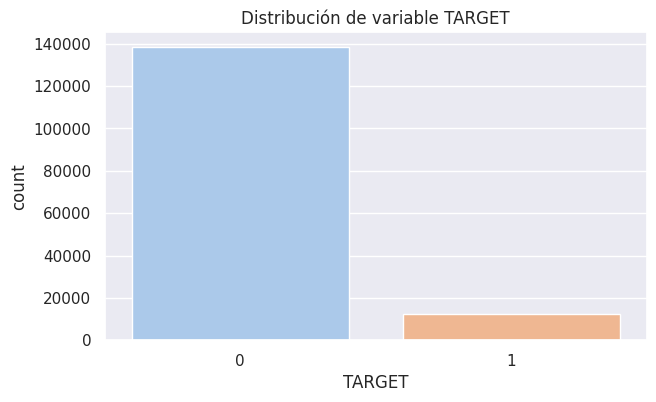

0    138515
1     12164
Name: TARGET, dtype: int64

In [ ]:
# Distribucion de variable TARGET
fig, ax = plt.subplots(figsize=(7,4),nrows=1)
sns.countplot(x = 'TARGET', data=solicitudes_train, palette="pastel", ax = ax)
ax.set_title('Distribución de variable TARGET')
plt.show()

solicitudes_train['TARGET'].value_counts()

Podemos darnos cuenta de que nos encontramos ante un dataset altamente desbalanceado, ya que la proporción de 0s y 1s es 11,4:1 aproximadamente. Debido a esto, para lograr un buen rendimiento de los modelos a implementar deberemos utilizar técnicas de undersampling y/o oversampling sobre la data para lograr un balance. Para este caso se aplicarán ambas tecnicas, llevando ambos valores a un rango medio entre ellos para evitar que la variación de uno solo sea brusca.

Otra forma que también puede usarse (y se utilizó) para el balanceo es el agregar pesos. El regresor logistico permite hacer esto.

In [ ]:
# Cantidad de filas y columnas de datos de entrenamiento y prueba

print("Cantidad de filas y columnas de los datos de entrenamiento")
print(solicitudes_train.shape[0])
print(solicitudes_train.shape[1])

Cantidad de filas y columnas de los datos de entrenamiento
150679
121


In [ ]:
# Cantidad de datos faltantes por columna en los datos de entrenamiento
print("Cantidad de NaN por columna en datos de entrenamiento: \n")
print(solicitudes_train.isnull().sum(axis = 0).sort_values(ascending=False).head(20))

Cantidad de NaN por columna en datos de entrenamiento: 

COMMONAREA_AVG              105261
COMMONAREA_MODE             105261
COMMONAREA_MEDI             105261
NONLIVINGAPARTMENTS_AVG     104582
NONLIVINGAPARTMENTS_MODE    104582
NONLIVINGAPARTMENTS_MEDI    104582
FONDKAPREMONT_MODE          102975
LIVINGAPARTMENTS_MEDI       102961
LIVINGAPARTMENTS_AVG        102961
LIVINGAPARTMENTS_MODE       102961
FLOORSMIN_AVG               102178
FLOORSMIN_MODE              102178
FLOORSMIN_MEDI              102178
YEARS_BUILD_AVG             100136
YEARS_BUILD_MEDI            100136
YEARS_BUILD_MODE            100136
OWN_CAR_AGE                  99515
LANDAREA_MEDI                89304
LANDAREA_AVG                 89304
LANDAREA_MODE                89304
dtype: int64


Notar que las 20 columnas revisadas (16,5% del total de columnas) tienen NaN y todas tienen sobre el 59% de sus filas sin datos.

Antes de proceder con la visualización de datos, primero reemplazaremos los datos nulos en el dataset de entrenamiento y en el de prueba.

Para datos categóricos y/o strings, se completarán los datos nulos con la moda, mientras que para datos de tipo numérticos, estos serán reemplazados con la mediana.

In [ ]:
def completar_nulos(df):

    data_copy = df.copy()
    # Revisión de si las columnas son numéricas o no
    int_columns = data_copy.select_dtypes(include=['int64']).columns.tolist()
    float_columns = data_copy.select_dtypes(include=['float64']).columns.tolist()
    numericas = float_columns + int_columns

    string_columns = data_copy.select_dtypes(exclude=[np.number]).columns.tolist()

    for column in numericas:
        data_copy[column] = data_copy[column].fillna((data_copy[column].median()))

    for column in string_columns:
        data_copy[column].fillna(data_copy[column].mode()[0], inplace=True)

    return data_copy

solicitudes_train_completo = completar_nulos(solicitudes_train)

In [ ]:
print(solicitudes_train_completo.isnull().sum(axis = 0).sum())

0


Ahora procederemos a visualizar la data de varias columnas.

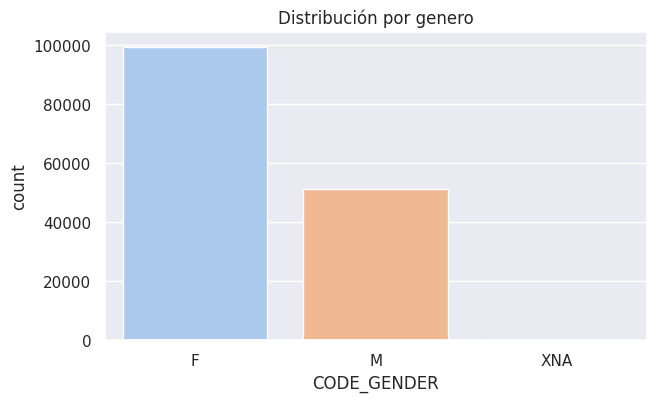

F      99488
M      51189
XNA        2
Name: CODE_GENDER, dtype: int64

In [ ]:
# Distribución de datos por genero

fig, ax = plt.subplots(figsize=(7,4),nrows=1)
sns.countplot(x = 'CODE_GENDER', data=solicitudes_train_completo, palette="pastel", ax = ax)
ax.set_title('Distribución por genero')
plt.show()

solicitudes_train['CODE_GENDER'].value_counts()

In [ ]:
# Distribución deuda pagada por genero
groupGen = solicitudes_train_completo.groupby(['CODE_GENDER'])['TARGET'].value_counts()
groupGen

CODE_GENDER  TARGET
F            0         92567
             1          6921
M            0         45946
             1          5243
XNA          0             2
Name: TARGET, dtype: int64

Femenino: 7% no paga (6921 personas)

Masculino: 10% no paga (5243 personas)

In [ ]:
# Descripción de datos de ingresos

solicitudes_train_completo['AMT_INCOME_TOTAL'].describe()

count    1.506790e+05
mean     1.681505e+05
std      1.099289e+05
min      2.610000e+04
25%      1.125000e+05
50%      1.485000e+05
75%      2.025000e+05
max      1.800009e+07
Name: AMT_INCOME_TOTAL, dtype: float64

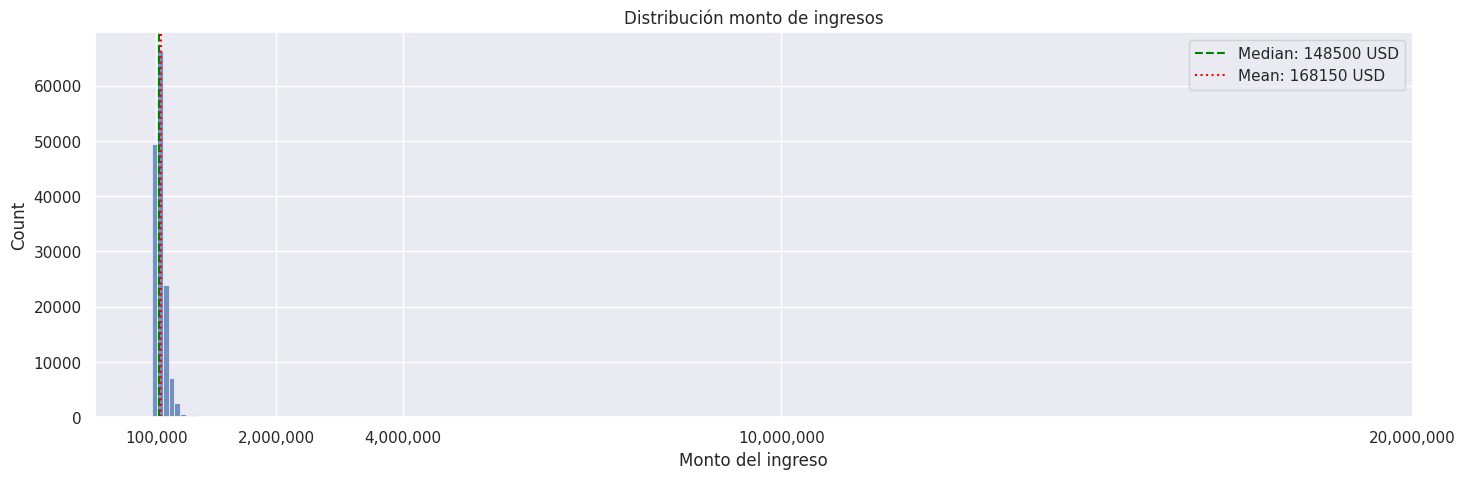

In [ ]:
plt.figure(figsize=(17,5))
plt.xlabel('Monto del ingreso')
plt.title('Distribución monto de ingresos')
sns.histplot(solicitudes_train_completo['AMT_INCOME_TOTAL'],bins=200,kde=False)
plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].median(),
            linestyle='--',
            color='green',
            label='Median: {} USD'.format(int(np.median(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].mean(),
            linestyle=':',
            color='red',
            label='Mean: {} USD'.format(int(np.mean(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.legend(loc=0)

x_ticks = [100000,  2000000, 4000000, 10000000, 20000000]
x_labels = ['100,000', '2,000,000', '4,000,000', '10,000,000', '20,000,000']

plt.xticks(x_ticks, x_labels)

plt.show()

La gráfica anterior no deja ver claramente la distribución, ya que los datos que pasan de 450.000 son muy pocos y hacen que el gráfico se vea desbalanceado.

Debido a esto , tomamos el 99% de los datos que se encuentran entre 0 y 450.000 e hicimos nuevamente el gráfico donde podemos tener una mejor apreciación de la distribución.

In [ ]:
#np.array(solicitudes_train_completo['AMT_INCOME_TOTAL']).percentile(0.8)
print(np.percentile(solicitudes_train_completo['AMT_INCOME_TOTAL'],99))

450000.0


In [ ]:
solicitudes_train_99 = solicitudes_train_completo[solicitudes_train_completo['AMT_INCOME_TOTAL'] <= 450000]

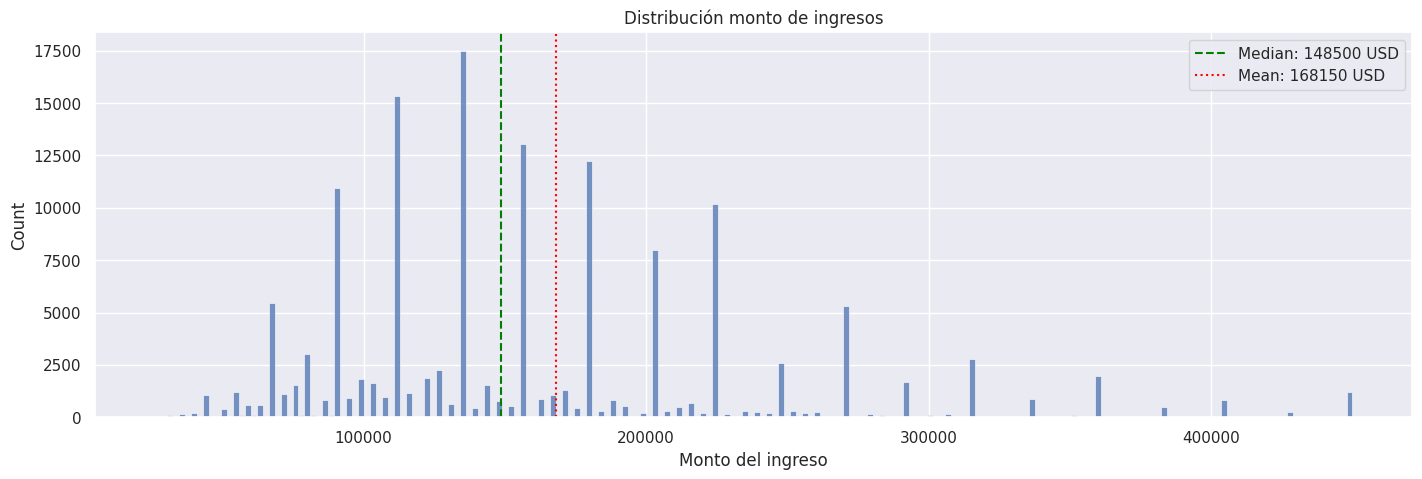

In [ ]:
plt.figure(figsize=(17,5))
plt.xlabel('Monto del ingreso')
plt.title('Distribución monto de ingresos')
sns.histplot(solicitudes_train_99['AMT_INCOME_TOTAL'],bins=200,kde=False)
plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].median(),
            linestyle='--',
            color='green',
            label='Median: {} USD'.format(int(np.median(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].mean(),
            linestyle=':',
            color='red',
            label='Mean: {} USD'.format(int(np.mean(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.legend(loc=0)

#x_ticks = [100000,  2000000, 4000000, 10000000, 20000000]
#x_labels = ['100,000', '2,000,000', '4,000,000', '10,000,000', '20,000,000']

#plt.xticks(x_ticks, x_labels)

plt.show()

In [ ]:
solicitudes_train_completo['AMT_CREDIT'].describe()

count    1.506790e+05
mean     5.993161e+05
std      4.015602e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.174190e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

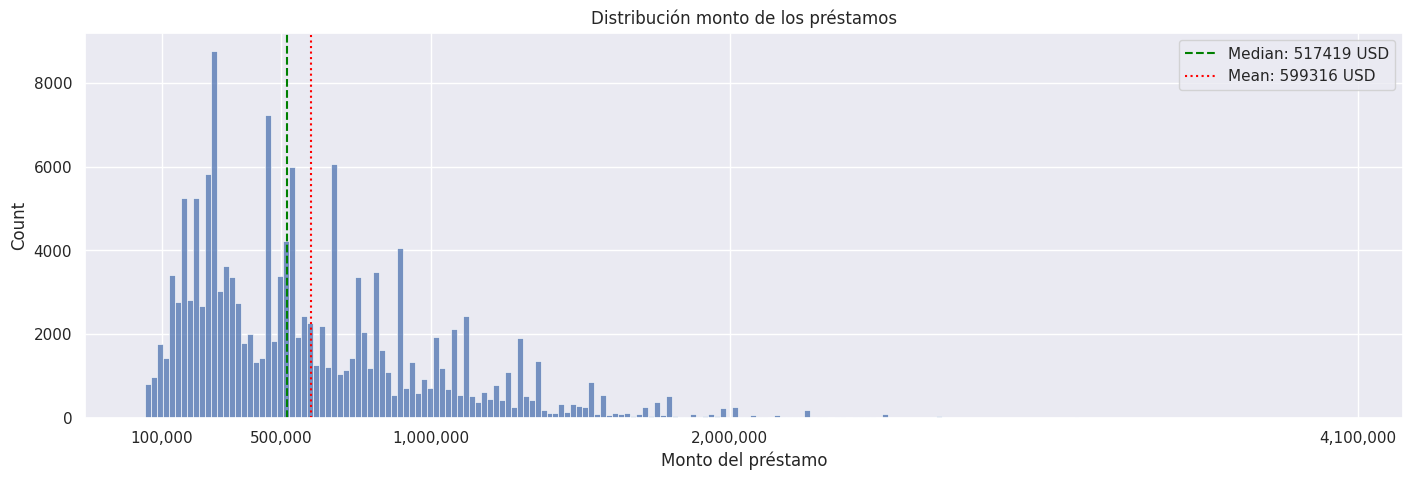

In [ ]:
plt.figure(figsize=(17,5))
plt.xlabel('Monto del préstamo')
plt.title('Distribución monto de los préstamos')
sns.histplot(solicitudes_train_completo['AMT_CREDIT'],bins=200,kde=False)
plt.axvline(x=solicitudes_train_completo['AMT_CREDIT'].median(),
            linestyle='--',
            color='green',
            label='Median: {} USD'.format(int(np.median(solicitudes_train_completo['AMT_CREDIT']))))

plt.axvline(x=solicitudes_train_completo['AMT_CREDIT'].mean(),
            linestyle=':',
            color='red',
            label='Mean: {} USD'.format(int(np.mean(solicitudes_train_completo['AMT_CREDIT']))))

plt.legend(loc=0)

x_ticks = [100000, 500000, 1000000, 2000000, 4100000]
x_labels = ['100,000', '500,000', '1,000,000', '2,000,000', '4,100,000']

plt.xticks(x_ticks, x_labels)

plt.show()

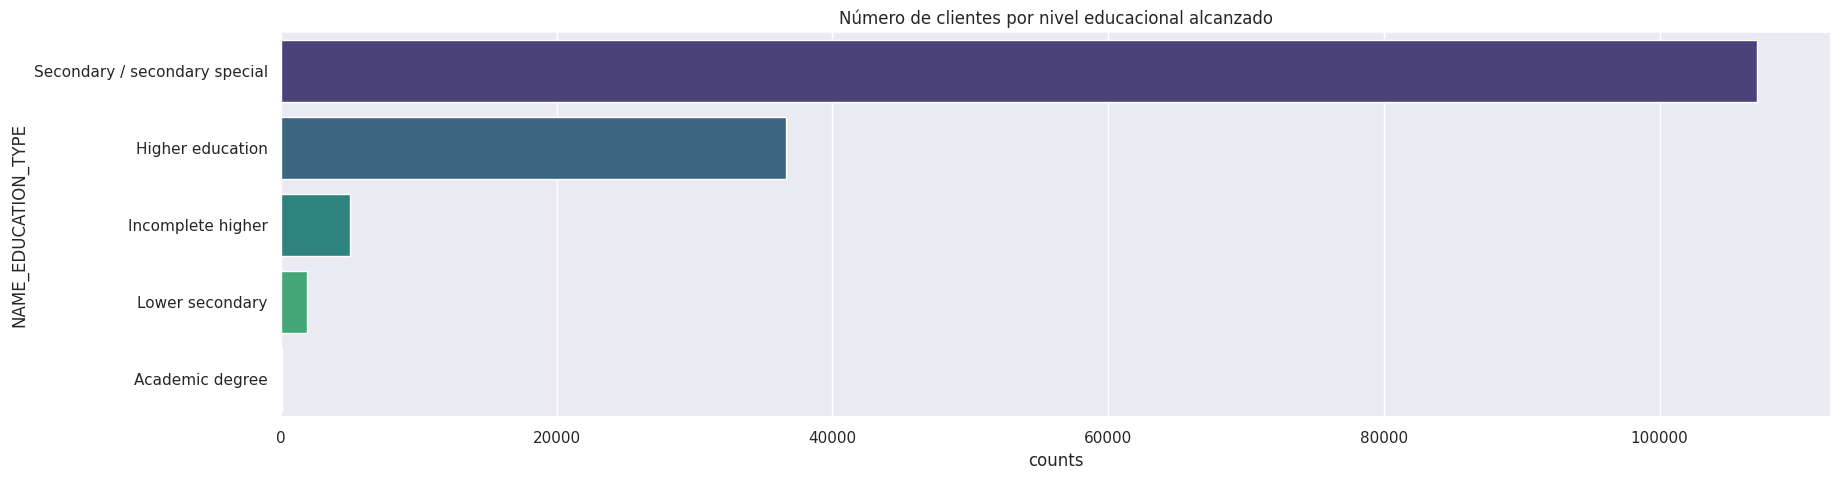

In [ ]:
tipoEduc = solicitudes_train_completo.groupby(['NAME_EDUCATION_TYPE']).size().reset_index(name='counts')
tipoEduc = tipoEduc.sort_values(by='counts', ascending=False)

fig, ax = plt.subplots(figsize=(20,5),nrows=1)
sns.barplot(data=tipoEduc, y='NAME_EDUCATION_TYPE', x='counts', palette="viridis",ax=ax)
ax.set_title('Número de clientes por nivel educacional alcanzado')
plt.show()

In [ ]:
group = solicitudes_train_completo.groupby(['NAME_EDUCATION_TYPE'])['TARGET'].value_counts()
group

NAME_EDUCATION_TYPE            TARGET
Academic degree                0            70
                               1             1
Higher education               0         34676
                               1          1972
Incomplete higher              0          4594
                               1           408
Lower secondary                0          1683
                               1           211
Secondary / secondary special  0         97492
                               1          9572
Name: TARGET, dtype: int64

Hay una fuerte relación entre que menor sea su nivel educacional, más probable es que no paguen su credito.

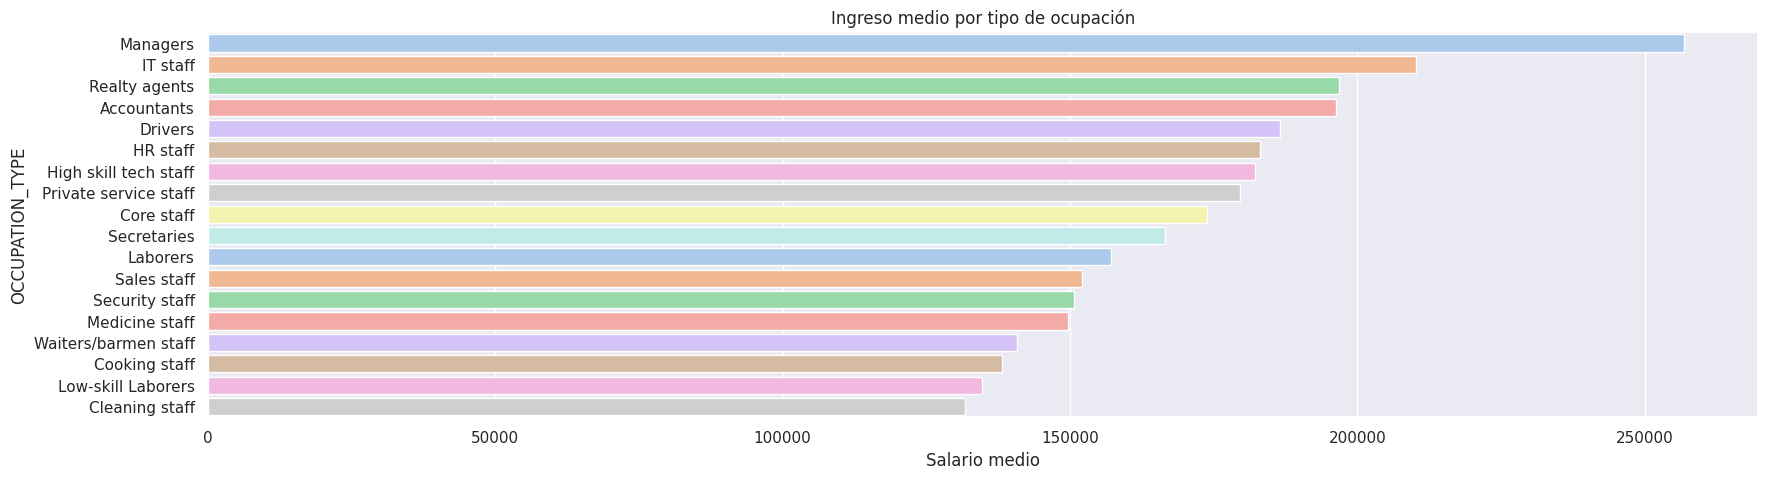

In [ ]:
ocupacion = solicitudes_train_completo.groupby(['OCCUPATION_TYPE']).mean()['AMT_INCOME_TOTAL'].reset_index(name='mean')
ocupacion = ocupacion.sort_values(by='mean',ascending=False)

fig, ax = plt.subplots(figsize=(20,5),nrows=1)
sns.barplot(data=ocupacion, y='OCCUPATION_TYPE', x='mean', palette="pastel",ax=ax)
ax.set_xlabel('Salario medio')
ax.set_title('Ingreso medio por tipo de ocupación')
plt.show()

In [ ]:
groupy = solicitudes_train_completo.groupby(['OCCUPATION_TYPE'])['TARGET'].value_counts()
groupy

OCCUPATION_TYPE        TARGET
Accountants            0          4619
                       1           214
Cleaning staff         0          2095
                       1           220
Cooking staff          0          2636
                       1           308
Core staff             0         12473
                       1           845
Drivers                0          8169
                       1          1071
HR staff               0           267
                       1            19
High skill tech staff  0          5147
                       1           341
IT staff               0           250
                       1            17
Laborers               0         68455
                       1          5924
Low-skill Laborers     0           860
                       1           179
Managers               0          9859
                       1           670
Medicine staff         0          3937
                       1           280
Private service staff  0          

Text(0.5, 1.0, 'Count of TARGET by OCCUPATION_TYPE')

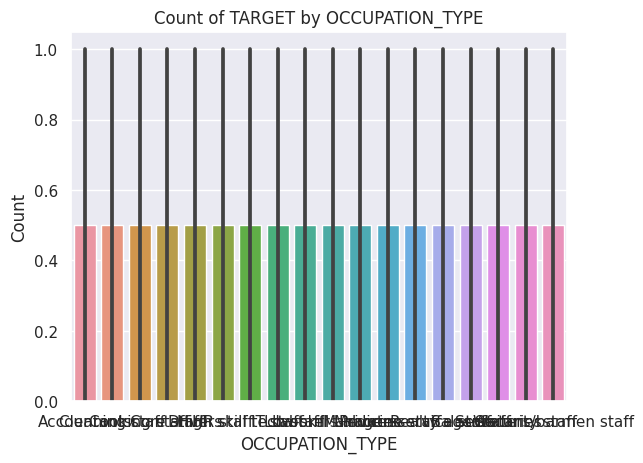

In [ ]:
# GRAFICO A CAMBIAR, SE VE HORRIBLE
groupy_df = groupy.reset_index(name='COUNT')
sns.barplot(data=groupy_df.reset_index(), x='OCCUPATION_TYPE', y='TARGET')

plt.xlabel('OCCUPATION_TYPE')
plt.ylabel('Count')
plt.title('Count of TARGET by OCCUPATION_TYPE')

La gente con trabajos de baja habilidad son quienes presentan el mayor porcentaje (21%) de clientes que no pagan.

In [ ]:
solicitudes_train_completo['DAYS_BIRTH'].describe()

count    150679.000000
mean     -16048.431892
std        4362.574783
min      -25201.000000
25%      -19695.000000
50%      -15770.000000
75%      -12429.000000
max       -7673.000000
Name: DAYS_BIRTH, dtype: float64

Mayor: 69 años

Menor: 21 años

# Codificacion

## Borrando NaNs

In [ ]:
nans_cols = []
for idx, row in pd.DataFrame(request_train_df.isna().sum()).iterrows():
  if row[0] == 0:
    nans_cols.append(idx)

# Importante la utilización de copy para que python explicite un nuevo espacio de memoria para nuevo dataframe
request_train_filtered_df = request_train_df[nans_cols].copy()
request_train_filtered_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,331475,0,Cash loans,F,Y,Y,0,135000.0,835380.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
1,366488,0,Cash loans,F,N,Y,0,103500.0,659533.5,Pensioner,...,0,0,0,0,0,0,0,0,0,0
2,444791,0,Cash loans,F,N,Y,0,135000.0,219042.0,Working,...,0,0,0,0,0,0,0,0,0,0
3,112960,0,Revolving loans,F,N,Y,0,67500.0,675000.0,Working,...,0,0,0,0,0,0,0,0,0,0
4,418735,0,Revolving loans,F,N,Y,0,315000.0,900000.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150674,244356,0,Cash loans,M,N,Y,0,112500.0,112068.0,Working,...,0,0,0,0,0,0,0,0,0,0
150675,213955,0,Cash loans,F,N,Y,0,135000.0,781920.0,State servant,...,0,0,0,0,0,0,0,0,0,0
150676,376877,0,Revolving loans,F,N,Y,0,135000.0,202500.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
150677,246747,0,Cash loans,F,N,N,1,135000.0,508495.5,Working,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
objectColumns = request_train_filtered_df.select_dtypes(include=['object']).columns.tolist()
objectColumns.remove('WEEKDAY_APPR_PROCESS_START')
objectColumns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'ORGANIZATION_TYPE']

In [ ]:
order_WEEKDAY_APPR_PROCESS_START = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
request_train_filtered_df['WEEKDAY_APPR_PROCESS_START'] = OrdinalEncoder(categories=[order_WEEKDAY_APPR_PROCESS_START]).fit_transform(request_train_filtered_df[['WEEKDAY_APPR_PROCESS_START']])

In [ ]:
ohe_X1 = OneHotEncoder(handle_unknown = 'ignore')
encoded_data = ohe_X1.fit_transform(request_train_filtered_df[objectColumns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe_X1.get_feature_names_out(objectColumns))

request_train_filtered_df = pd.concat([request_train_filtered_df, encoded_df], axis=1)
request_train_filtered_df.drop(columns=objectColumns, inplace=True)

In [ ]:
X1_train, X1_val, y1_train, y1_val = train_test_split(request_train_filtered_df.drop(columns = ['TARGET','SK_ID_CURR']), request_train_filtered_df['TARGET'],stratify = request_train_filtered_df['TARGET'], test_size = 0.2, random_state = 125)

## Cambiando NaNs y balanceando clases

In [ ]:
def fill_missing_median(df):
    string_columns = df.select_dtypes(include=['object'])
    df[string_columns.columns] = df[string_columns.columns].fillna(df[string_columns.columns].mode().iloc[0])
    numeric_columns = df.select_dtypes(include=['number'])
    df[numeric_columns.columns] = df[numeric_columns.columns].fillna(df[numeric_columns.columns].median())
    return df

def fill_missing_avg(df):
    string_columns = df.select_dtypes(include=['object'])
    df[string_columns.columns] = df[string_columns.columns].fillna(df[string_columns.columns].mode().iloc[0])
    numeric_columns = df.select_dtypes(include=['number'])
    df[numeric_columns.columns] = df[numeric_columns.columns].fillna(df[numeric_columns.columns].mean())
    return df

train_median = fill_missing_median(request_train_df.copy())
#train_avg = fill_missing_avg(request_train_df.copy())

In [ ]:
objectColumns = train_median.select_dtypes(include=['object']).columns.tolist()
objectColumns.remove('WEEKDAY_APPR_PROCESS_START')
objectColumns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
order_WEEKDAY_APPR_PROCESS_START = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
train_median['WEEKDAY_APPR_PROCESS_START'] = OrdinalEncoder(categories=[order_WEEKDAY_APPR_PROCESS_START]).fit_transform(train_median[['WEEKDAY_APPR_PROCESS_START']])

In [ ]:
ohe_X2 = OneHotEncoder(handle_unknown = 'ignore')
encoded_data = ohe_X2.fit_transform(train_median[objectColumns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe_X2.get_feature_names_out(objectColumns))

train_median = pd.concat([train_median, encoded_df], axis=1)
train_median.drop(columns=objectColumns, inplace=True)

In [ ]:
X2_temp, X2_val, y2_temp, y2_val = train_test_split(train_median.drop(columns = ['TARGET','SK_ID_CURR']), train_median['TARGET'], test_size = 0.2, random_state = 125)

In [ ]:
X2_temp.insert(0,'TARGET', y2_temp)

In [ ]:
fraud_detected  = X2_temp[X2_temp['TARGET'] == 1]
non_fraud  = X2_temp[X2_temp['TARGET'] == 0]

In [ ]:
## Balanceo de la data
fraud_detected_oversampled = resample(
    fraud_detected,
    replace=True,
    n_samples=round(len(non_fraud)/2),
    random_state=42
)
non_fraud_undersampled = resample(
    non_fraud,
    replace=False,
    n_samples=len(fraud_detected_oversampled),
    random_state=42
)
final_balanced_train_data = pd.concat([fraud_detected_oversampled, non_fraud_undersampled])
X2_train = final_balanced_train_data.drop(columns = ['TARGET'])
y2_train = final_balanced_train_data['TARGET']

# Modelos

In [ ]:
## Codigo de MayumyCH
## https://github.com/MayumyCH/credit_card_project_pyhton/blob/main/proyecto_notebook.ipynb

LABELS = ["Permanencia", 'Fuga']

def mostrar_resultados(y_test, rf_predictions):
    Matriz_Confusion = confusion_matrix(y_test, rf_predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(Matriz_Confusion, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='BrBG',linewidths = 0.5);
    plt.title("Matriz de confusión")
    plt.ylabel('Actual')
    plt.xlabel('Predicha')
    plt.show()
    print (classification_report(y_test, rf_predictions))

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs, y_test, y_train_res):
    """Compara modelos de Machine Learning a traves de la Curva ROC"""

    baseline = {}

    baseline['recall'] = recall_score(y_test,
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5

    results = {}

    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)

    train_results = {}
    train_results['recall'] = recall_score(y_train_res, train_predictions)
    train_results['precision'] = precision_score(y_train_res, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_res, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

    # Calcula la tasa de falso positivos y verdaderos positivos
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plotea las curvas
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'modelo')
    plt.legend();
    plt.xlabel('Tasa - Falsos Positivos');
    plt.ylabel('Tasa - Verdaderos Positivos'); plt.title('Curva ROC');
    plt.show();

In [ ]:
mejor_valor = 0

## 1ra Forma
* Se utiliza LogisticRegression
* Se utilizan los datos eliminando todos los NaNs

In [ ]:
class_weights = {0: 1, 1: 5}

base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(class_weight=class_weights, random_state=42))
])

param_grid = {
    'clf__C': np.logspace(-5,5,10),
    'clf__solver': ['newton-cholesky', 'sag', 'saga'],##Basado en la documentacion de LogisticRegression
    'clf__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X1_train, y1_train)

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

In [ ]:
best_model1 = grid_search.best_estimator_

pred = best_model1.predict(X1_val)
pred_probs = best_model1.predict_proba(X1_val)[:,1]

pred_train = best_model1.predict(X1_train)
pred_probs_train = best_model1.predict_proba(X1_train)[:,1]

test_auc = roc_auc_score(y1_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model1

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y1_val, y1_train)
plt.savefig('roc_auc_curve.png')

In [ ]:
mostrar_resultados(y1_val, pred)

## 2da Forma
* Se utiliza LogisticRegression
* Se utilizan los datos cambiando todos los NaNs

In [ ]:
class_weights = {0: 1, 1: 1}

base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(class_weight=class_weights, random_state=42))
])

param_grid = {
    'clf__C': np.logspace(-5,5,10),
    'clf__solver': ['newton-cholesky', 'sag', 'saga'],
    'clf__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X2_train, y2_train)

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

In [ ]:
best_model2 = grid_search.best_estimator_


pred = best_model2.predict(X2_val)
pred_probs = best_model2.predict_proba(X2_val)[:,1]

pred_train = best_model2.predict(X2_train)
pred_probs_train = best_model2.predict_proba(X2_train)[:,1]


test_auc = roc_auc_score(y2_val, predicciones)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model2

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y2_val, y2_train)
plt.savefig('roc_auc_curve.png')

In [ ]:
mostrar_resultados(y2_val, pred)

## 3ra Forma
* Se utiliza HistGradientBoostingClassifier
* Se utilizan los datos borrando todos los NaNs

In [ ]:
base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', HistGradientBoostingClassifier(random_state=125))
])

param_grid = {
    'clf__learning_rate': np.linspace(0.01,0.9,10),
    'clf__max_iter': [20, 40, 80, 160],
    'clf__max_depth': [3, 4, 5],
    'clf__l2_regularization': [0.0, 0.2, 0.5, 0.9]
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X1_train, y1_train)

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

In [ ]:
best_model3 = grid_search.best_estimator_

pred = best_model3.predict(X1_val)
pred_probs = best_model3.predict_proba(X1_val)[:,1]

pred_train = best_model3.predict(X1_train)
pred_probs_train = best_model3.predict_proba(X1_train)[:,1]

test_auc = roc_auc_score(y1_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model3

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y1_val, y1_train)
plt.savefig('roc_auc_curve.png')

In [ ]:
mostrar_resultados(y1_val, pred)

## 4ta Forma
* Se utiliza HistGradientBoostingClassifier
* Se utilizan los datos cambiando todos los NaNs

In [ ]:
base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', HistGradientBoostingClassifier(random_state=125))
])

param_grid = {
    'clf__learning_rate': np.linspace(0.01,0.9,10),
    'clf__max_iter': [20, 40, 80, 160],
    'clf__max_depth': [3, 4, 5],
    'clf__l2_regularization': [0.0, 0.2, 0.5, 0.9]
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X2_train, y2_train)

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

In [ ]:
best_model4 = grid_search.best_estimator_

pred = best_model4.predict(X2_val)
pred_probs = best_model4.predict_proba(X2_val)[:,1]

pred_train = best_model4.predict(X2_train)
pred_probs_train = best_model4.predict_proba(X2_train)[:,1]

test_auc = roc_auc_score(y2_val, pred)


print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model4

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y2_val, y2_train)
plt.savefig('roc_auc_curve.png')

In [ ]:
mostrar_resultados(y2_val, pred)

## 5ta Forma

* Se le agrega a la 2da forma un PCA en la pipeline

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

class_weights = {0: 1, 1: 1}

base = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca),
    ('clf', LogisticRegression(class_weight=class_weights, random_state=42))
])

param_grid = {
    "pca__n_components": [40, 80, 100, 150],
    'clf__C': np.logspace(-5,5,10),
    'clf__solver': ['newton-cholesky', 'sag', 'saga'],
    'clf__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X2_train, y2_train)

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

In [ ]:
best_model5 = grid_search.best_estimator_

pred = best_model5.predict(X2_val)
pred_probs = best_model5.predict_proba(X2_val)[:,1]

pred_train = best_model5.predict(X2_train)
pred_probs_train = best_model5.predict_proba(X2_train)[:,1]

test_auc = roc_auc_score(y2_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model5

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y2_val, y2_train)
plt.savefig('roc_auc_curve.png')

In [ ]:
mostrar_resultados(y2_val, pred)

## Guardar Mejor Modelo

In [ ]:
dump(mejor_modelo, 'filename.joblib')

# Testeo

In [ ]:
clasiffier_model = load('filename.joblib')
#clasiffier_model = best_model4

In [ ]:
train_median_Respuesta = fill_missing_median(request_test_df.copy())

objectColumns = train_median_Respuesta.select_dtypes(include=['object']).columns.tolist()
objectColumns.remove('WEEKDAY_APPR_PROCESS_START')

order_WEEKDAY_APPR_PROCESS_START = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
train_median_Respuesta['WEEKDAY_APPR_PROCESS_START'] = OrdinalEncoder(categories=[order_WEEKDAY_APPR_PROCESS_START]).fit_transform(train_median_Respuesta[['WEEKDAY_APPR_PROCESS_START']])

encoded_data = ohe_X2.transform(train_median_Respuesta[objectColumns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe_X2.get_feature_names_out(objectColumns))

train_median_Respuesta = pd.concat([train_median_Respuesta, encoded_df], axis=1)
train_median_Respuesta.drop(columns=objectColumns, inplace=True)



In [ ]:
SK_IDs_column = train_median_Respuesta['SK_ID_CURR'].values
predicciones = clasiffier_model.predict_proba(train_median_Respuesta.drop(columns = ['SK_ID_CURR']))
predicciones

In [ ]:
df = pd.DataFrame(list(zip(SK_IDs_column, predicciones)), columns=['SK_ID_CURR', 'TARGET'])
df